## Paper 1 Implementation: Plant Disease Detection Using Machine Learning

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import rand
import mahotas

In [2]:
images_per_class       = 250
fixed_size             = tuple((500, 500))
train_path             = 'dataset/train'
h5_train_data          = 'dataset/output/train_data.h5'
h5_train_labels        = 'dataset/output/train_labels.h5'
bins                   = 8

## Image Preprocessing

In [3]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [4]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [5]:
# Image Segmentation for Extraction of Green and Brown color


def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

## 3 types of feature descriptors

In [6]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [7]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [8]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [9]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


## Leaf Examples : Diseased Image Preprocessing Steps Visualized

In [10]:
#Diseased leaf Image 
#image_diseased = mpimg.imread("dataset/train/diseased/3.jpg")
image_diseased = mpimg.imread("dataset/train/diseased/image (1).jpg")
plt.title("Diseased Leaf Example")
plt.imshow(image_diseased)


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train/diseased/image (1).jpg'

In [11]:
##Fixed Size Image
#path = 'dataset/train/diseased/8.jpg'

path = 'dataset/train/diseased/image (3).jpg'
image = mpimg.imread(path)
fixedsizeimage = cv2.resize(image, fixed_size)

plt.imshow(fixedsizeimage)



FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train/diseased/image (3).jpg'

In [12]:
#RGB-BGR Conversion

rgbbgr=rgb_bgr(fixedsizeimage)

plt.imshow(rgbbgr)


NameError: name 'fixedsizeimage' is not defined

In [13]:
#BGR-HSV Conversion

bgrhsv=bgr_hsv(rgbbgr)
plt.imshow(bgrhsv)


NameError: name 'rgbbgr' is not defined

In [14]:
#Image Segmentation

segmentedimage=img_segmentation(rgbbgr,bgrhsv)
plt.imshow(segmentedimage)


NameError: name 'rgbbgr' is not defined

## Color Histogram

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train/healthy/image (1).jpg'

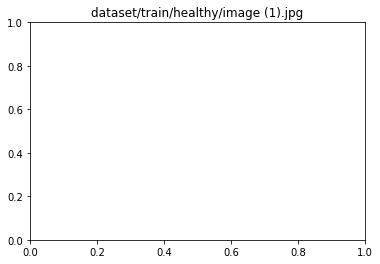

In [15]:
#fv_histogram  = fd_histogram(segmentedimage)
path_ = 'dataset/train/healthy/image (1).jpg'
#path_ = 'dataset/train/diseased/683.jpg'
plt.title(path_)
image_ = mpimg.imread(path_)

plt.imshow(image_)

colors=['r', 'g', 'b']

# split the image into its respective channels, then initialize the
chans = cv2.split(image_)

plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
# loop over the image channels
for (chan, color) in zip(chans, colors):
	# create a histogram for the current channel and plot it
	hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	plt.plot(hist, color=color)
	plt.xlim([0, 256])



In [16]:
#Healthy Leaf Image
image_healthy = mpimg.imread("dataset/train/healthy/image (1).jpg")
plt.title("Healthy Leaf Example")
plt.imshow(image_healthy)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train/healthy/image (1).jpg'

NameError: name 'conv2d_1_features' is not defined

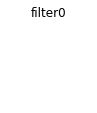

In [17]:
#List of image

import matplotlib.image as mpimg
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis')
plt.show()

## Global feature Extraction

In [18]:
# loop over the training data sub-folders (Either Diseased or Healthy)
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)
    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" +"image (" +str(x) +")"+ ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Feature Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
    
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        
        
        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: Apple___Apple_scab
[STATUS] processed folder: Apple___Black_rot
[STATUS] processed folder: Apple___Cedar_apple_rust
[STATUS] processed folder: Apple___healthy
[STATUS] completed Global Feature Extraction...


## Label Encoding the target and Scaling the features

In [19]:
# Encode The Target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("training labels encoded...!")

#Mapping of Target Labels (Diseased and Healthy)
le_name_mapping = dict(zip(targetNames,range(len(target))))

print(le_name_mapping)


training labels encoded...!
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3}


In [20]:
# Scale features from global features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler # Could use Standard Scaler too!
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("feature vector normalized...")

feature vector normalized...


## Saving Data using HDF5 (Hierarchical Data Format version 5)

In [21]:
# Save the feature vectors using HDF5 
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (1000, 532), type "<f8">

In [22]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))
h5f_data.close()

## Training ML Models 

In [23]:
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
#import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_train_data    = 'dataset/output/train_data.h5'
h5_train_labels  = 'dataset/output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))


# import the feature vector and trained labels from h5f files
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("Features shape: {}".format(global_features.shape))
print("Labels shape: {}".format(global_labels.shape))

print("Training Started...")

Features shape: (1000, 532)
Labels shape: (1000,)
Training Started...


## Splitting the training and testing data

In [24]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] splitted train and test data...
Train data  : (800, 532)
Test data   : (200, 532)


In [25]:
trainDataGlobal

array([[0.91734796, 0.01154887, 0.        , ..., 0.01100496, 0.02030923,
        0.86218557],
       [0.84196732, 0.        , 0.        , ..., 0.01100445, 0.02018745,
        0.86217073],
       [0.98721554, 0.00390411, 0.00768265, ..., 0.01099521, 0.01986752,
        0.8621875 ],
       ...,
       [0.96257403, 0.03312656, 0.01216835, ..., 0.01100499, 0.02020228,
        0.86216381],
       [0.91221327, 0.08202355, 0.01041347, ..., 0.01100488, 0.0199774 ,
        0.86216232],
       [0.86837093, 0.        , 0.01821119, ..., 0.01100438, 0.0200365 ,
        0.86215376]])

In [ ]:
#find mapping of test and train data to the file names

## Trained ML Algorithms Comparision

LR: 10 fold results :-
 [0.8875 0.8875 0.9    0.8875 0.9125 0.95   0.925  0.875  0.9375 0.8375]
mean: 0.900000  (0.031125)


LDA: 10 fold results :-
 [0.8375 0.8875 0.8125 0.8875 0.8    0.925  0.85   0.8375 0.8    0.825 ]
mean: 0.846250  (0.039548)


KNN: 10 fold results :-
 [0.85   0.8625 0.8125 0.9    0.825  0.8875 0.9125 0.8125 0.8125 0.7875]
mean: 0.846250  (0.040716)


CART: 10 fold results :-
 [0.825  0.8875 0.9    0.8125 0.8    0.8625 0.825  0.8125 0.8875 0.85  ]
mean: 0.846250  (0.034483)


RF: 10 fold results :-
 [0.925  0.925  0.9625 0.9125 0.9875 0.9625 0.9625 0.9    0.9625 0.925 ]
mean: 0.942500  (0.026926)


NB: 10 fold results :-
 [0.8125 0.8    0.7625 0.8125 0.8375 0.875  0.8375 0.8125 0.8375 0.8125]
mean: 0.820000  (0.028062)


SVM: 10 fold results :-
 [0.825  0.85   0.9    0.85   0.9    0.925  0.9125 0.825  0.9125 0.825 ]
mean: 0.872500  (0.039051)




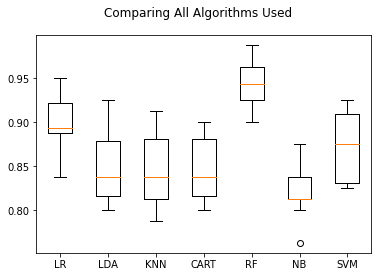

In [26]:
import matplotlib.pyplot as plt

# variables to hold the results and names
results = []
names   = []

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    print(name +': 10 fold results :-\n',cv_results )
    
    results.append(cv_results)
    
    names.append(name)
    msg = "%s: %f  (%f)" % ('mean', cv_results.mean(), cv_results.std())
    print(msg)
    print('\n')

# boxplot algorithm comparison
figure = plt.figure()
figure.suptitle('Comparing All Algorithms Used')
ax = figure.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Prediction Using Random Forest

In [27]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [28]:
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(random_state=9)

In [29]:
y_predict=clf.predict(testDataGlobal)

In [30]:
#Array of actual labels
testLabelsGlobal

array([1, 2, 0, 1, 3, 1, 1, 1, 1, 0, 0, 0, 3, 3, 0, 1, 2, 0, 1, 0, 1, 1,
       3, 0, 2, 3, 3, 2, 1, 2, 1, 3, 2, 2, 1, 3, 0, 1, 0, 1, 2, 2, 0, 0,
       3, 3, 3, 0, 3, 2, 1, 3, 3, 3, 0, 2, 2, 1, 1, 3, 2, 3, 0, 2, 3, 0,
       0, 2, 3, 0, 1, 0, 3, 3, 2, 0, 1, 2, 2, 2, 1, 1, 0, 3, 0, 2, 1, 2,
       0, 0, 0, 1, 3, 2, 2, 1, 3, 2, 1, 1, 1, 0, 3, 3, 3, 2, 2, 3, 1, 0,
       0, 1, 2, 0, 3, 2, 0, 0, 1, 0, 0, 3, 2, 1, 1, 1, 3, 0, 0, 1, 2, 2,
       1, 0, 1, 3, 3, 1, 0, 2, 2, 3, 0, 1, 1, 0, 0, 3, 3, 3, 2, 0, 2, 1,
       0, 3, 1, 1, 1, 2, 1, 2, 1, 3, 3, 1, 2, 3, 1, 3, 3, 3, 1, 0, 1, 1,
       0, 2, 1, 1, 3, 3, 2, 2, 3, 3, 2, 2, 1, 2, 0, 2, 1, 0, 0, 3, 2, 3,
       0, 1], dtype=int64)

In [31]:
# Number of actual diseased and Healthy plant leaves
y_actual=pd.Index(testLabelsGlobal)
y_actual.value_counts()

1    56
3    50
0    48
2    46
dtype: int64

In [32]:
#Array of predicted labels
y_predict

array([1, 2, 0, 1, 3, 1, 1, 1, 1, 0, 0, 0, 3, 3, 0, 1, 2, 3, 1, 0, 1, 1,
       3, 0, 2, 3, 3, 2, 1, 2, 1, 0, 2, 2, 1, 3, 0, 1, 0, 1, 2, 2, 0, 0,
       3, 3, 1, 0, 0, 2, 1, 3, 0, 3, 0, 2, 2, 1, 1, 3, 2, 3, 0, 2, 3, 0,
       3, 2, 0, 0, 1, 0, 0, 3, 2, 1, 1, 2, 2, 2, 1, 1, 0, 3, 0, 2, 1, 2,
       0, 0, 0, 1, 3, 2, 2, 1, 3, 2, 1, 1, 1, 1, 3, 3, 0, 2, 2, 3, 1, 0,
       0, 1, 2, 0, 3, 2, 0, 0, 1, 0, 0, 3, 2, 1, 1, 1, 3, 0, 0, 1, 2, 2,
       1, 0, 1, 3, 3, 1, 0, 2, 2, 3, 0, 1, 1, 0, 0, 3, 3, 3, 2, 0, 2, 1,
       0, 0, 1, 1, 1, 2, 1, 2, 1, 3, 3, 1, 2, 3, 1, 3, 3, 3, 1, 0, 1, 1,
       0, 2, 1, 1, 3, 3, 2, 2, 3, 3, 2, 2, 1, 2, 0, 2, 1, 0, 0, 3, 2, 3,
       0, 1], dtype=int64)

In [33]:
# Number of predicted diseased and Healthy plant leaves
y=pd.Index(y_predict)
y.value_counts()

1    59
0    51
2    46
3    44
dtype: int64

In [34]:
#Incorrectly Predicted plants (With indexes)
print(np.where(y_predict != testLabelsGlobal))
x=np.where(y_predict != testLabelsGlobal)[0]
print('Unmatched',x.size)

(array([ 17,  31,  46,  48,  52,  66,  68,  72,  75, 101, 104, 155],
      dtype=int64),)
Unmatched 12


In [35]:
#Table showing test labels and predicted labels for given test data of leaf images
import pandas as pd

df = pd.DataFrame({'Test':testLabelsGlobal, 'Predicted':y_predict})
df

,Test,Predicted
0,1,1
1,2,2
2,0,0
3,1,1
4,3,3
...,...,...
195,3,3
196,2,2
197,3,3
198,0,0


In [36]:
#Confusion Matrix
cf_matrix = confusion_matrix(testLabelsGlobal,y_predict)
cf_matrix


array([[44,  2,  0,  2],
       [ 0, 56,  0,  0],
       [ 0,  0, 46,  0],
       [ 7,  1,  0, 42]], dtype=int64)

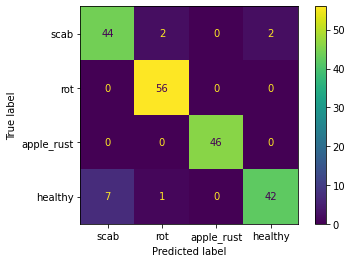

In [38]:
#Confusion Matrix Visualization

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(testLabelsGlobal, y_predict)
target_names=['scab','rot','apple_rust','healthy']
cmd = ConfusionMatrixDisplay(cm, display_labels=target_names)
#cmd = ConfusionMatrixDisplay(cm, display_labels=['Diseased 0','Healthy 1'])
cmd.plot()


In [39]:
accuracy_score(testLabelsGlobal, y_predict)

0.94

## Effect of Varying Random Forest hyperparameters

1. Sample size vs Accuracy 

In [ ]:
# explore random forest bootstrap sample size on performance
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore ratios from 10% to 100% in 10% increments
	for i in arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		# set max_samples=None to use 100%
		if i == 1.0:
			i = None
		models[key] = RandomForestClassifier(max_samples=i)
	return models


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

X=global_features
y=labels
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

2. Number of Trees vs Accuracy

In [ ]:
# explore random forest number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 

# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
X=global_features
y=labels
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Hybrid PSO-Random Forest Implementation

PSO Functions

In [42]:

# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    num_trees=opts['num_trees']
    seeds=['seeds']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']
    
    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug   
    # Training
    #mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error


# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)
        
    return cost



def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x
    

def pso(xtrain, ytrain, opts):
    # Default Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
    
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
  
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    #Stopping Criteria
    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        Gbin2       = binary_conversion(Xgb, thres, 1, dim) 
        Gbin2       = Gbin2.reshape(dim)
        pos2        = np.asarray(range(0, dim))
        sel_index2  = pos2[Gbin2 == 1]
        
       
        print("Feature Subset after {} iterations {}: ".format(t+1,sel_index2))
        
        # Store result
        curve[0,t] = fitG.copy()
        
        print("Iteration:", t + 1)
        
        print("Best (PSO):", curve[0,t])
        t += 1
        
        
        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
           
                
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return pso_data    

Feature Subset after 1 iterations [  1   2   3   4   5   8   9  10  12  13  14  15  16  17  18  19  20  22
  25  26  31  34  37  38  39  40  42  44  47  54  55  57  60  63  68  71
  72  74  75  77  81  82  84  86  87  88  89  91  94  95  99 101 103 104
 105 106 107 108 109 110 111 112 114 115 116 117 118 119 123 124 128 129
 130 136 137 139 140 141 145 146 148 152 154 156 157 158 161 162 164 167
 168 170 172 175 176 181 183 185 188 189 193 194 195 197 198 200 201 204
 207 208 209 210 211 213 214 215 216 218 220 221 223 225 226 231 232 233
 234 236 239 241 246 247 248 250 251 253 254 255 256 257 260 261 262 267
 269 270 271 272 273 275 277 278 279 280 281 282 286 289 290 291 293 294
 302 303 304 306 307 308 309 313 314 315 317 318 319 323 327 333 336 341
 342 343 347 351 352 353 354 356 357 362 363 365 366 368 369 371 373 375
 376 377 379 381 382 383 384 385 386 388 390 393 394 397 400 402 403 404
 405 406 410 412 413 414 415 416 417 418 424 426 427 428 433 434 438 439
 440 444 446 448 

Feature Subset after 8 iterations [  1   3   4   6  10  12  13  14  15  17  18  19  20  21  25  26  28  31
  33  37  38  39  40  44  45  47  51  52  54  55  57  63  68  71  73  77
  78  81  84  87  88  89  91  94  95  96 100 101 104 106 107 108 109 111
 114 115 116 117 123 126 128 129 130 133 134 136 137 138 139 140 141 143
 145 148 152 156 157 159 162 164 166 167 174 175 176 179 180 183 184 185
 188 189 191 193 194 195 197 199 202 204 208 209 210 213 216 218 219 220
 223 224 225 226 228 231 232 233 234 236 237 238 239 247 248 250 251 254
 256 257 260 261 262 269 270 271 272 275 279 280 281 282 286 287 289 290
 291 295 297 298 303 304 306 308 309 314 315 318 319 324 326 327 329 330
 336 341 342 343 347 349 351 352 353 354 356 357 359 362 363 364 365 367
 369 371 372 373 375 378 379 381 384 389 390 394 400 402 403 404 405 406
 410 413 414 415 416 417 418 424 426 427 428 433 434 436 439 440 442 444
 449 452 453 456 458 462 463 464 466 468 469 473 475 476 477 479 481 482
 484 486 487 492 

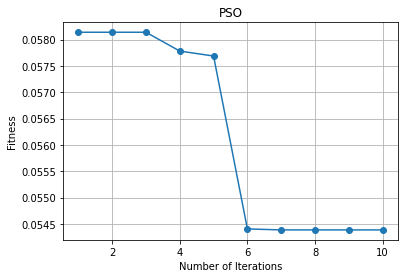

In [43]:
gasf=global_features

label=global_labels

# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(gasf, label, test_size=0.3, random_state=0, stratify=label)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# # parameter
# k    = 5     # k-value in KNN
# N    = 10    # number of particles
# T    = 100   # maximum number of iterations
# w    = 0.9   # inertia weight
# c1   = 2     # cognitive factor
# c2   = 2     # social factor 

# parameter
k    = 8     # k-value in KNN
num_trees=100  #random forest
seeds=9       #rf
N    = 20    # number of particles
T    = 10   # maximum number of iterations
w    = 0.5   # inertia weight
c1   = 2     # cognitive factor
c2   = 2     # social factor 
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2, 'num_trees':num_trees, 'seeds':seeds}

# perform feature selection
fmdl = pso(gasf, label, opts)
sf   = fmdl['sf']
print("fmdl",fmdl);

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train) 
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  

#Modelling using KNN
#mdl       = KNeighborsClassifier(n_neighbors = k) 

#Modelling using Random Forest
mdl  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
mdl.fit(x_train, y_train)

# Accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)
n_sf=[]
print(sf)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()